### 中央氣象局資料
#### [466990 花蓮測量站](https://codis.cwa.gov.tw/StationData)
- 選擇較齊全的資料
    - 全天空日射量(MJ/m^2)(TotalSolar)
    - 日照時數(Sunshine)
    - 紫外線指數(UV)
    - 站內大氣壓力(HPA)
    - 站內溫度(Temp)

In [1]:
import numpy as np
import pandas as pd
import sklearn
import os
def load_gov_data(path:str, subjects:list) :
    date_range = pd.date_range(start='2024-01-01 00:00:00', end='2024-10-31 23:00:00', freq='h')
    # date_range = date_range[(date_range.hour >= 9) & (date_range.hour <= 16)]
    date_index = date_range.strftime('%m-%d-%H')
    gov_data = pd.DataFrame(index=date_index)

    for subject in subjects :
        subject_df = pd.DataFrame()
        for mon in range(1, 11) :
            file_path = path+subject+f'_{mon}.csv'
            map_data = pd.read_csv(file_path)
            map_data = map_data.rename(columns={'24': '0'})
            # drop if columns have 總和
            map_data = map_data.drop(columns=[col for col in map_data.columns[1:] if not col.isdigit()])
            map_data = map_data.rename(columns={'日/時' : 'Day'})
            # drop if the last data is 總和
            map_data = map_data[map_data['Day'].apply(lambda x: (type(x) == int) or x.isdigit())]
            map_data['Day'] = map_data['Day'].astype(int)
            map_data = map_data.melt(id_vars=['Day'], var_name='Hour', value_name=subject)
            # print(map_data)
            map_data['Hour'] = map_data['Hour'].astype(int)
            # map_data = map_data[ (map_data['Hour'] >= 9) & (map_data['Hour'] <= 16)]
            map_data['Month'] = mon
            map_data['Month-Day-Hour'] = map_data['Month'].astype(str).str.zfill(2) + '-' + map_data['Day'].astype(str).str.zfill(2) + '-' + map_data['Hour'].astype(str).str.zfill(2)
            map_data = map_data.set_index('Month-Day-Hour')
            map_data = map_data.drop(columns=['Month', 'Day', 'Hour'])

            subject_df = pd.concat([subject_df, map_data], axis=0)
        gov_data = pd.concat([gov_data, subject_df], axis=1)
    return gov_data.astype(float)
gov_data = load_gov_data(path='./Gov_data/', subjects=['TotalSolar', 'UV', 'HPA', 'temp', 'Hum'])
gov_data['M-D-H'] = gov_data.index
gov_data


,TotalSolar,UV,HPA,temp,Hum,M-D-H
01-01-00,0.0,0.0,1019.7,17.1,79.0,01-01-00
01-01-01,0.0,0.0,1020.2,19.1,70.0,01-01-01
01-01-02,0.0,0.0,1019.9,18.7,70.0,01-01-02
01-01-03,0.0,0.0,1019.5,18.6,67.0,01-01-03
01-01-04,0.0,0.0,1019.3,18.7,65.0,01-01-04
...,...,...,...,...,...,...
10-31-19,0.0,0.0,992.7,25.7,95.0,10-31-19
10-31-20,0.0,0.0,993.6,25.3,95.0,10-31-20
10-31-21,0.0,0.0,994.2,25.6,95.0,10-31-21
10-31-22,0.0,0.0,994.1,25.5,94.0,10-31-22


### Load Train Data 

In [2]:
import numpy as np
import pandas as pd
import sklearn
import os
import matplotlib.pyplot as plt

def load_csv_folder(folder_path) :
    files = os.listdir(folder_path)
    csv_files = [file for file in files if file.endswith('csv')]
    
    data_frames = []
    for csv_file in csv_files :
        file_path = os.path.join(folder_path, csv_file)
        df = pd.read_csv(file_path)
        data_frames.append(df)
    return pd.concat(data_frames, ignore_index=True)


train1_path = './Traindata'
train2_path = './Additional_Traindata'

train1_data = load_csv_folder(train1_path)
train2_data = load_csv_folder(train2_path)
original_data = pd.concat([train1_data, train2_data], ignore_index=True)
# print(original_data['Hour'].max, original_data['Hour'].min)
original_data.shape

(1375028, 8)

### DateTime、合併相同時間的數據(相同地區)

In [3]:
train_data = original_data.copy()
print('異常數量:', sum(train_data['Sunlight(Lux)'] == 54612.5))
train_data['DateTime'] = pd.to_datetime(train_data['DateTime']).dt.floor('min')
train_data['Month'] = train_data['DateTime'].dt.month
train_data['Day'] = train_data['DateTime'].dt.day
train_data['Hour'] = train_data['DateTime'].dt.hour
train_data['10min_interval'] = train_data['DateTime'].dt.minute // 10

# 用成十分鐘一筆資料
# train_data = train_data.groupby(['LocationCode', 'Month', 'Day', 'Hour','10min_interval']).agg('mean').reset_index()
# train_data['Power(mW)'] = train_data['Power(mW)']*10
# train_data = train_data.sort_values(by=['LocationCode', 'DateTime'])
train_data['M-D-H'] = train_data['DateTime'].dt.strftime('%m-%d-%H')
train_data = train_data.drop(columns=['DateTime', 'WindSpeed(m/s)', 'Pressure(hpa)', 'Temperature(°C)', 'Humidity(%)'])
columns = train_data.columns[5:]
for col in columns :
    train_data[col] = train_data[col].round(2)
# train_data = train_data[ (train_data['Hour'] >= 9)&(train_data['Hour'] <= 16) ].reset_index(drop=True)

train_data = pd.merge(train_data, gov_data, left_on='M-D-H', right_on='M-D-H', how='left')

train_data.shape

異常數量: 3877


(1375028, 13)

### 處理不同LocationCode的相關資訊 - 位置、面朝向、高度
- 由於 LocationCode 17 為私人土地，其面朝向、高度設為其餘點的平均值

In [4]:
position = {
    1 : 1, 2 : 1, 3 : 1, 4 : 1, 5 : 1, 6 : 1, 7 : 1,  8 : 1, 9 : 1,  10: 1,  11: 1,  12: 1, 13: 1, 14:1,
    15: 2, 16: 2, 17: 2
}

direction = {
    1 : 181, 2 : 175, 3 : 180, 4 : 161, 5 : 208, 6 : 208, 7 : 172,  8 : 219, 9 : 151,  10: 223,  11: 131,  12: 298,
    13: 249, 14: 197,
    15: 127, 16: 82,
    17: 185
}

floor_height = 4.2
height = {
    1 : 38+4*floor_height, 2 : 38+4*floor_height, 3 : 38+4*floor_height, 4 : 38+4*floor_height,
    5 : 38+4*floor_height, 6 : 38+4*floor_height, 7 : 38+4*floor_height,  8 : 38+2*floor_height, 9 : 38+2*floor_height, 
    10: 38,  11: 38,  12: 38,
    13: 38+4*floor_height, 14: 38+4*floor_height,
    15: 12+4*floor_height, 16: 12+4*floor_height,
    17: 20
}
location_codes = train_data['LocationCode'].unique()
for code in location_codes :
    mask = train_data['LocationCode'] == code
    train_data.loc[mask, ['position']] = position[code]
    train_data.loc[mask, ['direction']] = direction[code]
    train_data.loc[mask, ['height']] = height[code]

tmp_data = train_data.copy()
train_data.shape

(1375028, 16)

### 數據分析
- Sunlight(Lux)
- 站內的Sunlight(Lux)分布

### 關於Sunlight(Lux)有奇怪的地方 : 在Sunlight==54612.5時，其power(mW)的範圍幾乎涵蓋全部

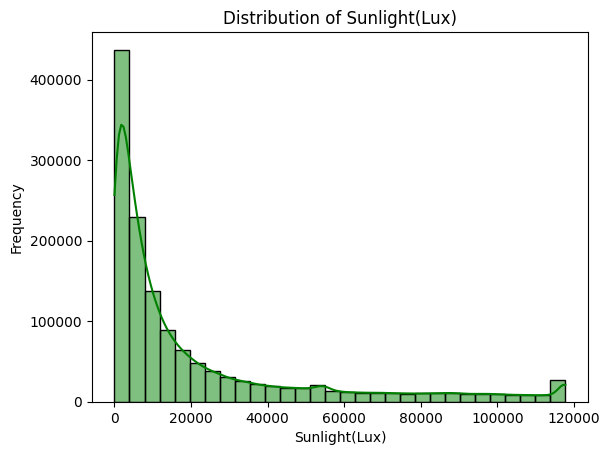

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

tmp = train_data.copy()
sns.histplot(tmp['Sunlight(Lux)'], bins=30, kde=True, color='green')
plt.xlabel('Sunlight(Lux)')
plt.ylabel('Frequency')
plt.title('Distribution of Sunlight(Lux)')
plt.show()

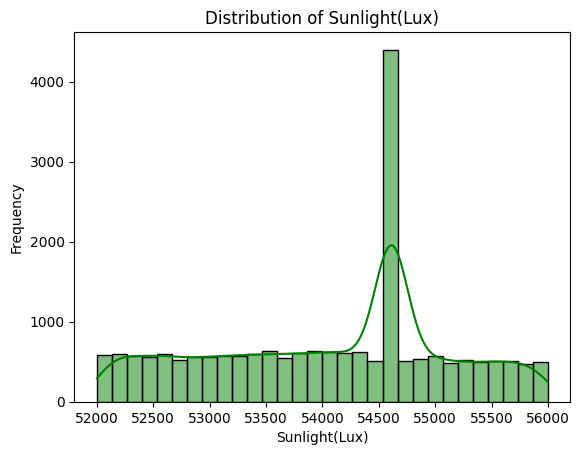

0    54612.5
Name: Sunlight(Lux), dtype: float64

In [6]:
tmp = train_data.copy()
tmp = tmp[(tmp['Sunlight(Lux)'] < 56000) & (tmp['Sunlight(Lux)'] > 52000)]
sns.histplot(tmp['Sunlight(Lux)'], bins=30, kde=True, color='green')
plt.xlabel('Sunlight(Lux)')
plt.ylabel('Frequency')
plt.title('Distribution of Sunlight(Lux)')
plt.show()
tmp['Sunlight(Lux)'].mode()

### 查看Sunlight(Lux)、Power(mW)在每個LocationCode的分布情況，決定選用LocationCode-1、2、5、7進行異常填補

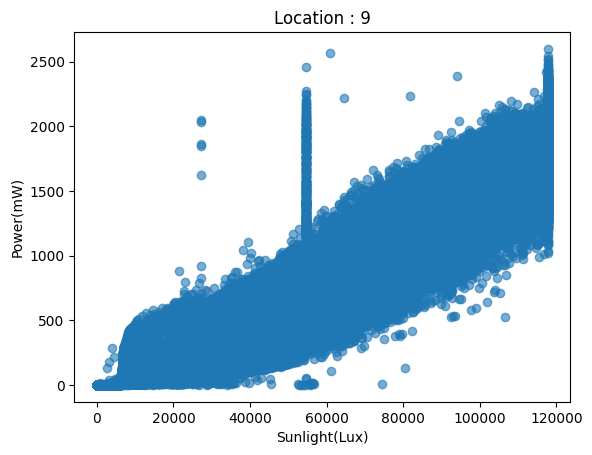

In [126]:
train_data = tmp_data.copy()
locations = train_data['LocationCode'].unique()

for loc in locations :
    mask = (train_data['LocationCode'] == loc)
    data = train_data[mask]
 
    colors = plt.get_cmap('hsv', len(data['Month'].unique()))
    plt.figure(figsize=(8, 6))
    # color = ['r', 'b', 'g']
    # for i, mon in enumerate([10]) :
    for i, mon in enumerate(data['Month'].unique()):
        mask = data['Month'] == mon
        mon_data = data[mask]
        if mon_data.shape[0] == 0 :
            continue
        plt.scatter(mon_data['Sunlight(Lux)'], mon_data['Power(mW)'], color=colors(i/(1+len(data['Month'].unique()))), alpha=0.6, label=mon)
        # plt.scatter(mon_data['Sunlight(Lux)'], mon_data['Power(mW)'], color=color[i], alpha=0.4, label=mon)
    plt.title(f"Location : {loc}")
    plt.xlabel("Sunlight(Lux)")
    plt.ylabel("Power(mW)")
    plt.legend()
    plt.show()

In [114]:
# XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
from xgboost import XGBRegressor


# np.random.seed(0)

def generate_ybins(y) :
    cnt = 11
    while True :
        bins = np.linspace(y.min(), y.max()+1, cnt)
        y_binned = np.digitize(y, bins) 
        counts = np.bincount(y_binned)[1:]
        if ~ ((counts <= 1).any()) :
            break
        cnt -= 1
    return y_binned

train_data = tmp_data.copy()

max_Sunlight = 117758.2
weird_Sunlight = 54612.5

# 取用LocationCode=1、2、5、7且不為max_Sunlight的資料
mask = ((train_data['LocationCode'] ==  5) | (train_data['LocationCode'] ==  7) | (train_data['LocationCode'] ==  2) | (train_data['LocationCode'] ==  1)) & (train_data['Sunlight(Lux)'] != max_Sunlight)
x = train_data[mask].drop(columns=['10min_interval', 'M-D-H'])
y = train_data[mask]['Sunlight(Lux)']

mask_normal = (x['Sunlight(Lux)'] != weird_Sunlight)
x_normal = x[mask_normal].drop(columns=['Sunlight(Lux)'])
y_normal = np.log1p(y[mask_normal])
    

x_abnormal = x[~mask_normal].drop(columns='Sunlight(Lux)')
best_params = {'colsample_bytree': 0.95, 'learning_rate': 0.3, 'max_depth': 12, 'n_estimators': 450, 'subsample': 0.95} 


y_binned = generate_ybins(y_normal)
x_train, x_test, y_train, y_test = train_test_split(
    x_normal, y_normal, test_size=0.2, random_state=0, stratify=y_binned
)


best_model = XGBRegressor(**best_params, objective='reg:squarederror', random_state=0)
best_model.fit(x_train, y_train)

mse_prediction = np.expm1(best_model.predict(x_test))
err = mean_squared_error(np.expm1(y_test), mse_prediction)
print(f"best_params = {best_params} ","mse = {:,}".format(round(err)))

# modify
best_model.fit(x_normal, y_normal)
prediction = np.expm1(best_model.predict(x_abnormal))
train_data.loc[x_abnormal.index, 'Sunlight(Lux)'] = prediction

data1 = train_data.copy()

best_params = {'colsample_bytree': 0.95, 'learning_rate': 0.3, 'max_depth': 12, 'n_estimators': 450, 'subsample': 0.95}  mse = 2,524,740


### Sunlight(Lux)因為光照度感測器最大值所限，最大數值僅達117758.2 lux。
- 使用Ridge將LocationCode : 1、2、5、7校正回較真實的Sunlight(Lux)數值

In [115]:
# Ridge
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures, RobustScaler
from sklearn.metrics import mean_squared_error
import numpy as np
from xgboost import XGBRegressor



train_data = data1.copy()

max_Sunlight = 117758.2
mask = ((train_data['LocationCode'] ==  5) | (train_data['LocationCode'] ==  7) | (train_data['LocationCode'] ==  2) | (train_data['LocationCode'] ==  1))
x = train_data[mask].drop(columns=['M-D-H'])
y = train_data[mask]['Sunlight(Lux)']

mask_not_max = (x['Sunlight(Lux)'] != max_Sunlight)
# print("最高Sunlight(Lux) 數量 :", sum(x['Sunlight(Lux)'] == max_Sunlight))
# print('> max_Sunlight : ', sum(x[mask_not_max]['Sunlight(Lux)'] > max_Sunlight))
x_not_max = x[mask_not_max].drop(columns=['Sunlight(Lux)'])
y_not_max = y[mask_not_max]
    
x_eq_max = x[~mask_not_max].drop(columns='Sunlight(Lux)')


y_binned = generate_ybins(y_not_max) 
x_train, x_test, y_train, y_test = train_test_split(
    x_not_max, y_not_max, test_size=0.2, random_state=0, stratify=y_binned
)

degree = 3
poly = PolynomialFeatures(degree=degree)
x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.transform(x_test)

# 使用StandardScaler會有問題
scaler = RobustScaler()
x_train_scaled = scaler.fit_transform(x_train_poly)
x_test_scaled = scaler.transform(x_test_poly)

best_model = Ridge(random_state=0)
best_model.fit(x_train_scaled, y_train)

mse_prediction = best_model.predict(x_test_scaled)
err = mean_squared_error(y_test, mse_prediction)
print(f'degree = {degree} ',"{:,}".format(round(err)))

x_eq_max_poly = poly.transform(x_eq_max)
x_eq_max_scaled = scaler.transform(x_eq_max_poly)
prediction = best_model.predict(x_eq_max_scaled)
train_data.loc[x_eq_max.index, 'Sunlight(Lux)'] = prediction
print( sum(prediction > max_Sunlight) , len(prediction) )


data2 = train_data.copy()
# degree = 3  12,571,140
# 3184 6755

degree = 3  15,922,571
3471 7307


### 用XGBRegressor把其餘LocationCode分布怪異的Sunlight(Lux)校正回來

In [116]:
# XGBRegreesor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

train_data = data2.copy()

mask = ((train_data['LocationCode'] ==  5) | (train_data['LocationCode'] ==  7) | (train_data['LocationCode'] ==  2) | (train_data['LocationCode'] ==  1))
x = train_data[mask].drop(columns=['LocationCode', '10min_interval', 'Sunlight(Lux)', 'M-D-H', 'position'])
y = np.log1p(train_data[mask]['Sunlight(Lux)'])
x_modified  = train_data[~mask].drop(columns=['LocationCode', '10min_interval', 'Sunlight(Lux)', 'M-D-H', 'position'])

best_params = {'colsample_bytree': 0.95, 'learning_rate': 0.1, 'max_depth': 12, 'n_estimators': 450, 'subsample':0.95}

y_binned = generate_ybins(y) 
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=0, stratify=y_binned
)


best_model = XGBRegressor(**best_params, objective='reg:squarederror', random_state=0)
best_model.fit(x_train, y_train)

mse_prediction = np.expm1(best_model.predict(x_test))
err = mean_squared_error(np.expm1(y_test), mse_prediction)
print(f'best_params = {best_params} ', "mse = {:,}".format(round(err)))

# modify
best_model.fit(x, y)
prediction = np.expm1(best_model.predict(x_modified))
train_data.loc[~mask, 'Sunlight(Lux)'] = prediction

best_params = {'colsample_bytree': 0.95, 'learning_rate': 0.1, 'max_depth': 12, 'n_estimators': 450, 'subsample': 0.95}  mse = 2,839,419


In [ ]:
# Ridge
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor

train_data = data2.copy()

mask = (train_data['LocationCode'] == 5) | (train_data['LocationCode'] == 7)
x = train_data[mask].drop(columns=['LocationCode', '10min_interval', 'Sunlight(Lux)', 'M-D-H', 'position', 'direction', 'height'])
y = np.log1p(train_data[mask]['Sunlight(Lux)'])
# x_modified  = train_data[~mask].drop(columns=['LocationCode', '10min_interval', 'Sunlight(Lux)', 'M-D-H', 'position', 'direction', 'height'])

bins = np.linspace(y.min(), y.max()+1, 11)
y_binned = np.digitize(y, bins) 
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=0, stratify=y_binned
)

degree = 2
poly = PolynomialFeatures(degree=degree)
scaler = StandardScaler()
best_model = Ridge(random_state=0)

# x_train_poly = poly.fit_transform(x_train)
# x_test_poly = poly.transform(x_test)

# x_train_scaled = scaler.fit_transform(x_train_poly)
# x_test_scaled = scaler.fit_transform(x_test_poly)

# best_model.fit(x_train_scaled, y_train)

# mse_prediction = np.expm1(best_model.predict(x_test_scaled))
# err = mean_squared_error(np.expm1(y_test), mse_prediction)
# print(f'degree = {degree} ', "{:,}".format(round(err)))

# modify
x_poly = poly.fit_transform(x)
x_scaled = scaler.fit_transform(x_poly)
best_model.fit(x_scaled, y)

for loc in train_data['LocationCode'].unique():
    if loc in [5, 7] :
        continue
    # print(f'=========={loc}========')
    mask = train_data['LocationCode'] == loc
    x_modified = train_data[mask].drop(columns=['LocationCode', '10min_interval', 'Sunlight(Lux)', 'M-D-H', 'position', 'direction', 'height'])
    x_modified_poly = poly.transform(x_modified)
    x_modified_scaled = scaler.transform(x_modified_poly)
    prediction = np.expm1(best_model.predict(x_modified_scaled))
    train_data.loc[x_modified.index, 'Sunlight(Lux)'] = prediction
    
data3 = train_data.copy()
# train-validation
# degree = 5  81,406,221
# degree = 4  106,745,898

### Model Training
- 先預測Sunlight(Lux)再預測Power(mW)

### 壓縮到十分鐘的平均

In [117]:
train_data = data3.copy()
train_data = train_data.drop(columns=['M-D-H'])
print(train_data.shape[0])
train_data = train_data.groupby(['LocationCode', 'Month', 'Day', 'Hour','10min_interval']).agg('mean').reset_index()
print(train_data.shape[0])
train_data = train_data.sort_values(by=['LocationCode'])

1375028
140495


In [118]:
# XGBRegressor - Sunlight(Lux)
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np


x = train_data.drop(columns=['Sunlight(Lux)', 'Power(mW)', 'LocationCode'])
y = np.log1p(train_data['Sunlight(Lux)'])


y_binned = generate_ybins(y)
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=0, stratify=y_binned
)
best_params_sunlight = {'colsample_bytree': 0.95, 'learning_rate': 0.3, 'max_depth': 12, 'n_estimators': 350, 'subsample':0.95}


model_sunlight = XGBRegressor(**best_params_sunlight, objective='reg:squarederror', random_state=0)
model_sunlight.fit(x_train, y_train)
prediction = np.expm1(model_sunlight.predict(x_test))
err = mean_squared_error(np.expm1(y_test), prediction)

print(f'best_params_sunlight = {best_params_sunlight}', f'mse : {round(err):,}')


best_params_sunlight = {'colsample_bytree': 0.95, 'learning_rate': 0.3, 'max_depth': 12, 'n_estimators': 350, 'subsample': 0.95} mse : 40,132,725


In [120]:
# XGBRegressor - power
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from scipy.stats import uniform, randint

# x = train_data.drop(columns=['Sunlight(Lux)', 'Power(mW)'])
y = np.log1p(train_data['Sunlight(Lux)'])
model_sunlight.fit(x, y)
prediction = np.expm1(model_sunlight.predict(x))
x['Sunlight(Lux)'] = prediction

# x = train_data.drop(columns=['Power(mW)', 'M-D-H'])
y = train_data['Power(mW)']

y_binned = generate_ybins(y) 
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=0, stratify=y_binned
)

best_params_power = {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 14, 'n_estimators': 300}
model_power = XGBRegressor(**best_params_power, objective='reg:absoluteerror', random_state=0)
model_power.fit(x_train, y_train)

prediction = model_power.predict(x_test)
err = mean_squared_error(y_test, prediction)
print(f'best_params_power = {best_params_power}',f"power mse : {np.round(mean_absolute_error(y_test, prediction)*9600):,}")


best_params_power = {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 14, 'n_estimators': 300} power mse : 105,387.0


### Load Test Data 並且用中央氣象局的資料進行特徵擴增

In [121]:
test_data = pd.read_csv('upload.csv')
output = test_data.copy()
test_data['LocationCode'] = test_data['序號'].astype(str).str[-2:].astype(int)
test_data['DateTime'] = pd.to_datetime(test_data['序號'].astype(str).str[:-2])
test_data['Month'] = test_data['DateTime'].dt.month
test_data['Day'] = test_data['DateTime'].dt.day
test_data['Hour'] = test_data['DateTime'].dt.hour
test_data['10min_interval'] = test_data['DateTime'].dt.minute // 10
test_data['M-D-H'] = test_data['DateTime'].dt.strftime("%m-%d-%H")
test_data = test_data.drop(columns=['DateTime'])

test_data = pd.merge(test_data, gov_data, left_on='M-D-H', right_on='M-D-H', how='left')
test_data = test_data.drop(columns=['M-D-H'])

for code in test_data['LocationCode'].unique() :
    mask = test_data['LocationCode'] == code
    test_data.loc[mask, ['position']] = position[code]
    test_data.loc[mask, ['direction']] = direction[code]
    test_data.loc[mask, ['height']] = height[code]
tmp_test_data = test_data.copy()
test_data.head()

,序號,答案,LocationCode,Month,Day,Hour,10min_interval,TotalSolar,UV,HPA,temp,Hum,position,direction,height
0,20240117090001,NaN,1,1,17,9,0,0.62,1.0,1022.0,18.7,83.0,1.0,181.0,54.8
1,20240117091001,NaN,1,1,17,9,1,0.62,1.0,1022.0,18.7,83.0,1.0,181.0,54.8
2,20240117092001,NaN,1,1,17,9,2,0.62,1.0,1022.0,18.7,83.0,1.0,181.0,54.8
3,20240117093001,NaN,1,1,17,9,3,0.62,1.0,1022.0,18.7,83.0,1.0,181.0,54.8
4,20240117094001,NaN,1,1,17,9,4,0.62,1.0,1022.0,18.7,83.0,1.0,181.0,54.8


### 預測Test Data的答案

In [122]:
x = train_data.drop(columns=['Sunlight(Lux)', 'Power(mW)'])
y = np.log1p(train_data['Sunlight(Lux)'])
model_sunlight.fit(x, y)
prediction = np.expm1(model_sunlight.predict(x))
x['Sunlight(Lux)'] = prediction
y = train_data['Power(mW)']
model_power.fit(x, y)

test_data['Sunlight(Lux)'] = np.expm1(model_sunlight.predict(test_data[x.drop(columns=['Sunlight(Lux)']).columns]))
test_data['答案']= model_power.predict(test_data[x.columns])
test_data.loc[test_data['答案'] < 0, '答案'] = 0
test_data

,序號,答案,LocationCode,Month,Day,Hour,10min_interval,TotalSolar,UV,HPA,temp,Hum,position,direction,height,Sunlight(Lux)
0,20240117090001,201.812332,1,1,17,9,0,0.62,1.0,1022.0,18.7,83.0,1.0,181.0,54.8,30862.509766
1,20240117091001,262.739685,1,1,17,9,1,0.62,1.0,1022.0,18.7,83.0,1.0,181.0,54.8,33303.644531
2,20240117092001,167.388351,1,1,17,9,2,0.62,1.0,1022.0,18.7,83.0,1.0,181.0,54.8,28431.607422
3,20240117093001,187.540558,1,1,17,9,3,0.62,1.0,1022.0,18.7,83.0,1.0,181.0,54.8,29739.677734
4,20240117094001,198.933044,1,1,17,9,4,0.62,1.0,1022.0,18.7,83.0,1.0,181.0,54.8,31152.757812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9595,20241002161012,1.123411,12,10,2,16,1,0.42,1.0,1005.8,26.8,78.0,1.0,298.0,38.0,2840.983887
9596,20241002162012,1.800598,12,10,2,16,2,0.42,1.0,1005.8,26.8,78.0,1.0,298.0,38.0,3575.801514
9597,20241002163012,0.906681,12,10,2,16,3,0.42,1.0,1005.8,26.8,78.0,1.0,298.0,38.0,2642.536377
9598,20241002164012,0.213177,12,10,2,16,4,0.42,1.0,1005.8,26.8,78.0,1.0,298.0,38.0,1004.600891


In [123]:
test_data = test_data[['序號', '答案']]
test_data.loc[:, '答案'] = np.round(test_data['答案'], 2)
test_data
test_data.to_csv('answer.csv', index=False)